In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sortedcontainers import SortedDict
import matplotlib.pyplot as plt

In [28]:
def PrintSortDict(sd):
    for k in sd.keys():
        print(f"{k}: {sd[k]}")

def PrintKeys(sd):
    for k in sd.keys():
        print(f"{k}; ")

def PrintScope(sd):
    for k in sd.keys():
        print(f"Vizinhos de {k.id}: ")
        for kk in sd[k].keys():
            print(f"{kk.id}: {sd[k][kk]}")

In [65]:
def PrintHullA(polar_hull):
    x = []
    y = []
    for key in polar_hull.keys():
        x.append(key.x)
        y.append(key.y)
    x.append(x[0])
    y.append(y[0])
    plt.plot(x, y, marker='o', color='b')

def PrintPoints(rb):
    x = []
    y = []
    for k in rb.keys():
        x.append(k.x)
        y.append(k.y)
    plt.scatter(x,y)

def PrintHullsAndSeparator(ph_one,ph_two,sep):
    fig, ax = plt.subplots()
    x = []
    y = []
    for key in ph_one.keys():
        x.append(key.x)
        y.append(key.y)
    x.append(x[0])
    y.append(y[0])
    ax.plot(x, y, marker='o', color='b')
    x = []
    y = []
    for key in ph_two.keys():
        x.append(key.x)
        y.append(key.y)
    x.append(x[0])
    y.append(y[0])
    ax.plot(x, y, marker='o', color='r')
    x_limits = ax.get_xlim()
    y_limits = ax.get_ylim()
    ax.set_ylim(y_limits)
    slope, inter = sep
    x = x_limits
    y = []
    y.append(slope*x[0]+inter)
    y.append(slope*x[1]+inter)
    ax.plot(x,y,color='g')
    

In [100]:
class Point:
    id = 1
    def __init__(self,a,b, c = 0, shake=1e-5):
        self.id = Point.id
        Point.id+=1
        shakes = np.random.uniform(-shake, shake, 2)
        self.x = a+shakes[0]
        self.y = b+shakes[1]
        self.classe = c

    def __add__(self, other):
        if isinstance(other, Point):
            return Point(self.x+other.x, self.y+other.y)
        elif isinstance(other, np.ndarray):
            return Point(self.x+other[0],self.y+other[1],shake=0)
        else:
            raise TypeError("Unsupported operand type")
        
    def __sub__(self, other):
        if isinstance(other, Point):
            return Point(self.x-other.x, self.y-other.y)
        else:
            raise TypeError("Unsupported operand type")
        
    def __truediv__(self,other):
        return Point(self.x/other,self.y/other)
        
    def __str__(self):
        return str(self.id)+": "+str(self.x)+"   "+str(self.y)
    

    def __lt__(self,other):
        if isinstance(other, Point):
            vec_prod = (self.x*other.y)-(self.y*other.x)
            if vec_prod>0:
                return True
            elif vec_prod<0 or (self.x==other.x and self.y==other.y):
                return False            
            else:
                raise Exception(f"Segments ending in {self} and {other} are parallel")
        else:
            raise TypeError("Unsupported operand type")
        
    
        
    def Shake(self,shake):
        shakes = np.random.uniform(-shake,shake,2)
        self.x+=shakes[0]
        self.y+=shakes[1]
        return self

    def Reset():
        Point.id = 1

def X_Coord(point):
    return point.x

In [30]:
class Segment:
    id = 1
    def __init__(self,a: Point, b: Point, enforce_order=True, shake = 0):
        if b.x<a.x and enforce_order:
            temp = a
            a = b
            b = temp
        self.bgn = a.Shake(shake)
        self.end = b.Shake(shake)
        self.slope = (self.end.y-self.bgn.y)/(self.end.x-self.bgn.x)
        self.intercept = self.end.y - (self.slope * self.end.x)
        self.id = Segment.id
        Segment.id+=1
        
    
    def Y_At_X(self,x):
        return self.slope*x+self.intercept


    def Invert(self):
        temp = self.bgn
        self.bgn = self.end
        self.end = temp


    def __str__(self):
        return "Id: "+str(self.id)+"\nBegin: "+str(self.bgn.x)+"   "+str(self.bgn.y)+"\nEnd: "+str(self.end.x)+"   "+str(self.end.y)
    
    def __lt__(self,other):
        if isinstance(other, Segment):
            return self.bgn.x < other.bgn.x
        else:
            raise TypeError("Unsupported operand type")
        
    def Reset():
        Segment.id = 1

In [31]:
class LimitPoint:
    def __init__(self,p,i):
        self.point = p
        self.is_end = i

    def __lt__(self,other):
        if isinstance(other, LimitPoint):
            return self.point.x < other.point.x
        else:
            raise TypeError("Unsupported operand type")

## Primitivas

In [32]:
def Clockwise(a: Segment, b: Segment): #returns true if a is clockwise to b
    frst_seg = a.end - a.bgn
    scnd_seg = b.end - b.bgn
    vec_prod = (frst_seg.x*scnd_seg.y)-(frst_seg.y*scnd_seg.x)
    if vec_prod>0:
        return True
    elif vec_prod<0:
        return False
    else:
        print(a)
        print(b)
        raise Exception("Segments are parallel")

In [33]:
def SegmentsIntercept(a: Segment,b: Segment):
    check_one = Clockwise(a,Segment(a.bgn,b.bgn))
    check_two = Clockwise(a,Segment(a.bgn,b.end))
    if check_one==check_two:
        return False
    check_one = Clockwise(b,Segment(b.bgn,a.bgn))
    check_two = Clockwise(b,Segment(b.bgn,a.end))
    if check_one==check_two:
        return False
    return True

## Data reading and pre-processing

In [34]:
def SetTwoDimensions(df):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df)
    df_pca = pd.DataFrame(data = pca_result, columns = ['x', 'y'])
    return df_pca

In [35]:
def PreProcessData(path, tgtCol):
    df = pd.read_csv(path)
    tgtData = df.iloc[:, tgtCol]  # Save the nth column
    df = df.drop(df.columns[tgtCol], axis=1)
    df = SetTwoDimensions(df)
    df['target_data'] = tgtData
    return df

In [36]:
def ExtractPoints(df):
    rb_tree_points = SortedDict(X_Coord)
    for i in range(len(df)):
        p = Point(df.loc[i, "x"], df.loc[i, "y"], df.loc[i,"target_data"])
        rb_tree_points[p] = None
    return rb_tree_points


In [37]:
def ReadData(path, tgtCol):
    df = PreProcessData(path, tgtCol)
    rb_tree_points = ExtractPoints(df)
    return rb_tree_points


## Convex Hull

In [38]:
def get_next_key(sd, key):
    idx = sd.bisect(key)
    return sd.iloc[idx] if idx < len(sd) else sd.iloc[0]

def get_previous_key(sd, key):
    idx = sd.bisect_left(key)
    return sd.iloc[idx - 1] if idx > 0 else sd.iloc[len(sd)-1]

In [39]:
def print_convex_hull(hull,points):
    polar_hull = SortedDict()
    for key in hull.keys():
        polar_hull[key] = None

    keys = list(polar_hull.keys())
    x = []
    y = []
    for key in polar_hull.keys():
        x.append(key.x)
        y.append(key.y)
    x.append(x[0])
    y.append(y[0])

    ps = []
    for p in points.items():
        ps.append(p[0])
    xs = list(map(lambda p:p.x,ps))
    ys = list(map(lambda p:p.y,ps))

    plt.plot(x,y)
    plt.scatter(xs,ys)
    plt.show()

In [40]:
def ConvexHull(rb_tree_points):
    hull_points = SortedDict(lambda p:p.x)

    p0 = rb_tree_points.peekitem(0)[0]
    p1 = rb_tree_points.peekitem(1)[0]
    p2 = rb_tree_points.peekitem(2)[0]

    hull_points[p0] = None
    hull_points[p1] = None
    hull_points[p2] = None
    
    print_convex_hull(hull_points,rb_tree_points)

    #for p in hull_points.items():
        #print(p[0].x,p[0].y)

    it_points = list(rb_tree_points.keys())
    for p in it_points[3:]:
        j = -1
        
        #Update upper bound
        u = j
        p_i_m1 = (j-1) % len(hull_points)
        
        while(Clockwise(
                        Segment(hull_points.items()[p_i_m1][0],p),
                        Segment(hull_points.items()[p_i_m1][0],hull_points.items()[u][0])
                        )):
            if(u != j):
                
                hull_points.pop(hull_points.items()[u][0])

            u = (u-1)%len(hull_points)
            p_i_m1 = (u-1)%len(hull_points)
        
        #Update lower bound
        l = 0
        p_i_p2 = (l+1) % len(hull_points)

        while(Clockwise(
                        Segment(p,hull_points.items()[l][0]),
                        Segment(p,hull_points.items()[p_i_p2][0])
                        )
            ):
            if(l != u):  
                hull_points.pop(hull_points.items()[l][0])
            l = (l+1)%len(hull_points)
            p_i_p2 = (l+1)%len(hull_points)
        
        # Necessário encontrar uma função que insira o ponto em uma posição específica do ponto
        hull_points[p] = None
        #print_convex_hull(hull_points,rb_tree_points)
    return hull_points

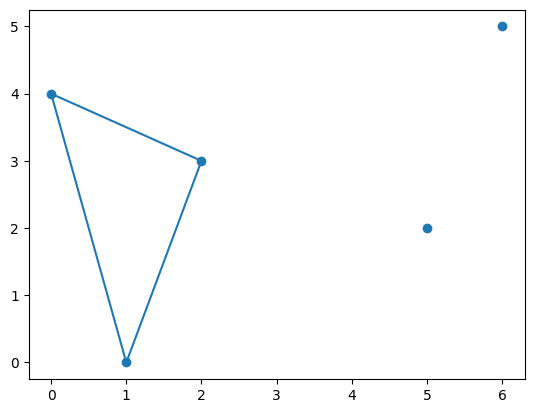

In [41]:
rbt = SortedDict(lambda p: p.x)
#Test convex hull
p1 = Point(1,0)
p2 = Point(2,3)
p3 = Point(5,2)
p4 = Point(6,5)
p5 = Point(0,4)

rbt[p1] = None
rbt[p2] = None
rbt[p3] = None
rbt[p4] = None
rbt[p5] = None

ch = ConvexHull(rbt)

In [42]:
rbt.keys()

SortedKeysView(SortedDict(<function <lambda> at 0x00000249965F9800>, {<__main__.Point object at 0x0000024996617E10>: None, <__main__.Point object at 0x0000024996543750>: None, <__main__.Point object at 0x0000024996615610>: None, <__main__.Point object at 0x0000024996601790>: None, <__main__.Point object at 0x00000249E3A49C90>: None}))

In [44]:
def ConvexHullA(rb_tree_points):
    #hull_points = SortedDict()
    polar_hull = SortedDict()
    p0 = rb_tree_points.peekitem(0)[0]
    p1 = rb_tree_points.peekitem(1)[0]
    p2 = rb_tree_points.peekitem(2)[0]
    #hull_points[PointWrap(p0)] = None
    #hull_points[PointWrap(p1)] = None
    #hull_points[PointWrap(p2)] = None
    polar_hull[p0] = None
    polar_hull[p1] = None
    polar_hull[p2] = None

    it_points = list(rb_tree_points.keys())
    for p in it_points[3:]:
        polar_hull[p] = None
        n = len(polar_hull)
        index_cclock_comparable = (polar_hull.index(p)+1)%n
        compare_cclock = polar_hull.iloc[index_cclock_comparable]   #first element to search counter-clockwise the vertex that links to p in the old hull
        searching_cclock = True


        index_clock_comparable = (polar_hull.index(p)-1)%n
        compare_clock = polar_hull.iloc[index_clock_comparable]      #first element to search clockwise the vertex that links to p in the old hull
        searching_clock = True
        #PrintKeys(polar_hull) ###
        del polar_hull[p]
        n = len(polar_hull)
        removal = dict()
        #searching for parallel segment counter_clockwise
        #print(f"The new point is {p}")
        while searching_cclock:
            index_cclock_comparable = polar_hull.index(compare_cclock)
            #print(f"The anchor is {compare_cclock}")
            window = [(index_cclock_comparable-1)%n, (index_cclock_comparable+1)%n]
            seg1 = Segment(polar_hull.iloc[window[1]], compare_cclock, enforce_order=False,shake=1e-5)
            seg2 = Segment(compare_cclock, polar_hull.iloc[window[0]], enforce_order=False,shake=1e-5)
            seg0 = Segment(compare_cclock, p, enforce_order=False, shake=1e-5)
            
            #print(f"Segments:\nseg0: {seg0}\nseg1: {seg1}\nseg2{seg2}")
            if Clockwise(seg1,seg0) != Clockwise(seg2,seg0):
                #print("Found")
                searching_cclock = False
            else:
                #print("Mark to remove:")
                #print(compare_cclock)
                removal[compare_cclock] = None
                #print("marked")
                compare_cclock = polar_hull.iloc[window[1]]

        #searching for parallel segment clockwise
        while searching_clock:
            index_clock_comparable = polar_hull.index(compare_clock)
            #print(f"The anchor is {compare_clock}")
            window = [(index_clock_comparable+1)%n, (index_clock_comparable-1)%n]
            seg1 = Segment(polar_hull.iloc[window[1]], compare_clock, enforce_order=False,shake=1e-5)##
            seg2 = Segment(compare_clock, polar_hull.iloc[window[0]], enforce_order=False,shake=1e-5)##
            seg0 = Segment(compare_clock, p, enforce_order=False,shake=1e-5)
            #print(f"Segments:\nseg0: {seg0}\nseg1: {seg1}\nseg2: {seg2}")
            if Clockwise(seg1,seg0) != Clockwise(seg2,seg0):
                #print("Found")
                searching_clock = False
            else:
                #print("Mark to remove:")
                #print(compare_clock)
                removal[compare_clock] = None
                #print("marked")
                compare_clock = polar_hull.iloc[window[1]]
        #print("removal")
        for to_remove in removal:
            #print(to_remove)
            #PrintKeys(polar_hull)
            del polar_hull[to_remove]
            #print("after removal")
            #PrintKeys(polar_hull)
    
        polar_hull[p] = None
        #hull_points[p] = None
    return polar_hull

C:\Users\User\AppData\Local\Temp\ipykernel_6100\924946608.py:19: DeprecationWarning: sorted_dict.iloc is deprecated. Use SortedDict.keys() instead.
  compare_cclock = polar_hull.iloc[index_cclock_comparable]   #first element to search counter-clockwise the vertex that links to p in the old hull


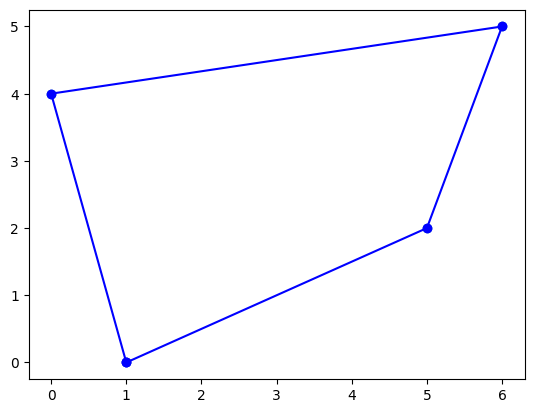

In [45]:
Point.Reset()
Segment.Reset()
rbt = SortedDict(lambda p: p.x)
#Test convex hull
p1 = Point(1,0)
p2 = Point(2,3)
p3 = Point(5,2)
p4 = Point(6,5)
p5 = Point(0,4)

rbt[p1] = None
rbt[p2] = None
rbt[p3] = None
rbt[p4] = None
rbt[p5] = None
#PrintPoints(rbt)
ph = ConvexHullA(rbt)
PrintPoints(ph)
PrintHullA(ph)

In [46]:
def ConvexHullA_BUG_NO_SISTEMA_ALGUEM_ME_DESCONFIGUROU(rb_tree_points):
    hull_points = SortedDict(X_Coord)
    polar_hull = SortedDict()
    p0 = rb_tree_points.peekitem(0)[0]
    p1 = rb_tree_points.peekitem(1)[0]
    p2 = rb_tree_points.peekitem(2)[0]
    hull_points[p0] = None
    hull_points[p1] = None
    hull_points[p2] = None
    polar_hull[p0] = None
    polar_hull[p1] = None
    polar_hull[p2] = None

    it_points = list(rb_tree_points.keys())
    for p in it_points[3:]:
        polar_hull[p] = None
        n = len(polar_hull)
        index_cclock_comparable = (polar_hull.index(p)+1)%n
        compare_cclock = polar_hull.iloc[index_cclock_comparable]   #first element to search counter-clockwise the vertex that links to p in the old hull
        searching_cclock = True


        index_clock_comparable = (polar_hull.index(p)-1)%n
        compare_clock = polar_hull.iloc[index_clock_comparable]      #first element to search clockwise the vertex that links to p in the old hull
        searching_clock = True
        PrintKeys(polar_hull) ###
        polar_hull.pop(p,0)
        n = len(polar_hull)
        removal = dict()
        #searching for parallel segment counter_clockwise
        print(f"The new point is {p}")
        while searching_cclock:
            index_cclock_comparable = polar_hull.index(compare_cclock)
            print(f"The anchor is {compare_cclock}")
            window = [(index_cclock_comparable-1)%n, (index_cclock_comparable+1)%n]
            seg1 = Segment(polar_hull.iloc[window[1]], compare_cclock, enforce_order=False,shake=1e-5)
            seg2 = Segment(compare_cclock, polar_hull.iloc[window[0]], enforce_order=False,shake=1e-5)
            seg0 = Segment(compare_cclock, p, enforce_order=False, shake=1e-5)
            
            print(f"Segments:\nseg0: {seg0}\nseg1: {seg1}\nseg2{seg2}")
            if Clockwise(seg1,seg0) != Clockwise(seg2,seg0):
                print("Found")
                searching_cclock = False
            else:
                print("Mark to remove:")
                print(compare_cclock)
                removal[compare_cclock] = None
                print("marked")
                compare_cclock = polar_hull.iloc[window[1]]

        #searching for parallel segment clockwise
        while searching_clock:
            index_clock_comparable = polar_hull.index(compare_clock)
            print(f"The anchor is {compare_clock}")
            window = [(index_clock_comparable+1)%n, (index_clock_comparable-1)%n]
            seg1 = Segment(polar_hull.iloc[window[1]], compare_clock, enforce_order=False,shake=1e-5)##
            seg2 = Segment(compare_clock, polar_hull.iloc[window[0]], enforce_order=False,shake=1e-5)##
            seg0 = Segment(compare_clock, p, enforce_order=False,shake=1e-5)
            print(f"Segments:\nseg0: {seg0}\nseg1: {seg1}\nseg2: {seg2}")
            if Clockwise(seg1,seg0) != Clockwise(seg2,seg0):
                print("Found")
                searching_clock = False
            else:
                print("Mark to remove:")
                print(compare_clock)
                removal[compare_clock] = None
                print("marked")
                compare_clock = polar_hull.iloc[window[1]]
        
        print("polar")
        PrintKeys(polar_hull)

        print("cartesian")
        PrintKeys(hull_points)
        for to_remove in removal:
            polar_hull.pop(to_remove,0)

            for key in hull_points.keys(): ###key saiu de hull_points

                if key==to_remove: 
                    print(key)###Bug porque não consegue achar key em hull_points
                    hull_points.pop(key) ###Bug porque não consegue achar key em hull_points
                    
        polar_hull[p] = None
        hull_points[p] = None
    return hull_points, polar_hull

In [47]:
for key in rbt.keys():
    print(rbt[key])

None
None
None
None
None


In [48]:
Point.Reset()
Segment.Reset()
rbt = SortedDict(lambda p: p.x)
#Test convex hull
p1 = Point(1,0)
p2 = Point(2,3)
p3 = Point(5,2)
p4 = Point(6,5)
p5 = Point(0,4)

rbt[p1] = None
rbt[p2] = None
rbt[p3] = None
rbt[p4] = None
rbt[p5] = None
#PrintPoints(rbt)
ch, ph = ConvexHullA_BUG_NO_SISTEMA_ALGUEM_ME_DESCONFIGUROU(rbt)
PrintPoints(ch)
#PrintHullA(ph)

1: 0.9999903436789241   8.634365834051313e-06; 
1: 5.000008235014411   2.000005497761502; 
1: 2.000009170217166   2.999990856937745; 
1: -9.69517199800618e-07   4.000002236012427; 
The new point is 1: 5.000008235014411   2.000005497761502
The anchor is 1: 2.000009170217166   2.999990856937745
Segments:
seg0: Id: 3
Begin: 2.0000060500603882   2.9999951464876866
End: 5.0000038645614495   2.0000117558403248
seg1: Id: 1
Begin: 7.909183532592527e-06   3.9999979681865785
End: 2.0000060500603882   2.9999951464876866
seg2Id: 2
Begin: 2.0000060500603882   2.9999951464876866
End: 0.9999962540936275   7.781513655203799e-06
Mark to remove:
1: 2.0000060500603882   2.9999951464876866
marked
The anchor is 1: 7.909183532592527e-06   3.9999979681865785
Segments:
seg0: Id: 6
Begin: 2.234679901636893e-05   3.9999945153983885
End: 5.000004945839149   2.0000058730329306
seg1: Id: 4
Begin: 1.0000045382449199   3.12134392821324e-07
End: 2.234679901636893e-05   3.9999945153983885
seg2Id: 5
Begin: 2.2346799016

C:\Users\User\AppData\Local\Temp\ipykernel_6100\1387362348.py:19: DeprecationWarning: sorted_dict.iloc is deprecated. Use SortedDict.keys() instead.
  compare_cclock = polar_hull.iloc[index_cclock_comparable]   #first element to search counter-clockwise the vertex that links to p in the old hull


ValueError: <__main__.Point object at 0x0000024996549A10> not in list

## Sweep Line

In [51]:
def GetSegments(polar_hull):
    #polar_hull = SortedDict()
    #for key in convex_hull.keys():
    #    polar_hull[key] = None
    n = len(polar_hull)
    keys = list(polar_hull.keys())
    segments_hull = SortedDict()
    count = 0
    for key in polar_hull.keys():
        shake = np.random.uniform(0, 1e-5, (2,2))
        next_key = keys[(count + 1) % n]
        if key.x<next_key.x:
            shake[1][0] *= -1
        else:
            shake[0][0] *= -1
        if key.y<next_key.y:
            shake[1][1] *= -1
        else:
            shake[0][1] *= -1
        s = Segment(key+shake[0],next_key+shake[1])
        count+=1
        segments_hull[s.bgn.x] = (s,0)
        segments_hull[s.end.x] = (s,1)
    return segments_hull

In [52]:
def SweepLine(segment_hull_one, segments_hull_two):
    segments_set = segment_hull_one.copy()
    segments_set.update(segments_hull_two)
    scope = SortedDict()
    for key in segments_set.keys():
        #print(key)
        current_segment, end = segments_set[key]
        if not end: #início do segmento
            #print(f"Início do segmento {current_segment.id}")
            comparisons = dict()
            for comparable_segment in scope.keys():
                aux = (current_segment.bgn.y>comparable_segment.Y_At_X(key))
                comparisons[comparable_segment] = aux
                scope[comparable_segment][current_segment] = not aux
            scope[current_segment] = comparisons
            #PrintScope(scope)
            
        else:                          #fim do segmento
            #print(f"Fim do segmento {current_segment.id}")
            comparisons = scope[current_segment]
            #PrintScope(scope)
            del scope[current_segment]
            for comparable_segment in scope.keys():
                aux = (current_segment.end.y>comparable_segment.Y_At_X(key))
                if comparisons[comparable_segment] != aux:
                    #print(f"Inteseção entre {current_segment.id} e {comparable_segment.id}")
                    return True
            
    return False

## Classes

In [132]:
def Distance(a: Point, b: Point):
    return np.sqrt((a.x-b.x)**2+(a.y-b.y)**2)

def SegFromPointToSeg(p:Point, s:Segment):
    ps_slope = -1/s.slope
    ps_inter = p.y-ps_slope*p.x
    x = (ps_inter-s.intercept)/(s.slope-ps_slope)
    y = ps_slope*x+ps_inter
    if x<s.bgn.x or x>s.end.x:
        return np.inf, None
    intermed_point = Point(x,y)
    d = Distance(p,intermed_point)
    return d, intermed_point

def SegFromPointToSegDev(p:Point, s:Segment):
    ps_slope = -1/s.slope
    ps_inter = p.y-ps_slope*p.x
    xp = np.array([-8.1, 8.1])
    yp = xp*ps_slope+ps_inter
    plt.plot(p.x,p.y,marker='o', color='y')
    plt.plot(xp,yp,color='r')
    xperp = np.array([s.bgn.x,s.end.x])
    yperp = np.array([s.bgn.y,s.end.y])
    plt.plot(xperp,yperp,color='b')
    x = (ps_inter-s.intercept)/(s.slope-ps_slope)
    y = ps_slope*x+ps_inter
    if x<s.bgn.x or x>s.end.x:
        return np.inf, None
    intermed_point = Point(x,y)
    plt.plot(x,y,marker='o',color='g')
    d = Distance(p,intermed_point)
    return d, intermed_point


In [133]:
def Classificator(ph_one, ph_two):
    min = np.inf
    for key in ph_one.keys():
        for kkey in ph_two.keys():
            d = Distance(key,kkey)
            if d<min:
                min = d
                closest_pair = (key,kkey)
    hulls = (ph_one,ph_two)
    distances = SortedDict()
    distances[d] = closest_pair
    print("closest points: ")
    
    for i in range(2):
        p = closest_pair[i]
        print(f"Point from hull {i}")
        print(p)
        next_point_index = (hulls[i].index(p)+1)%len(hulls[i])
        next_point = hulls[i].iloc[next_point_index]
        print("Next point")
        print(next_point)
        next_seg = Segment(p,next_point)
        d, intermed_point = SegFromPointToSeg(closest_pair[(i+1)%2],next_seg)
        print("distance to the closest of another polygon")
        print(d)
        if d!=np.inf:
            distances[d] = (intermed_point,closest_pair[(i+1)%2])

        prev_point_index = (hulls[i].index(p)-1)%len(hulls[i])
        prev_point = hulls[i].iloc[prev_point_index]
        print("Previous point")
        print(prev_point)
        ''''
        Point from hull 1
        6: 5.000001760804929   1.9999966583671591
        
        Previous point
        8: 8.000003952213047   2.999991979966869

        distance to the closest of another polygon
        3.0799045333543653e-06
        '''
        prev_seg = Segment(p,prev_point)
        d, intermed_point = SegFromPointToSeg(closest_pair[(i+1)%2],prev_seg)
        print("distance to the closest of another polygon")
        print(d)
        if d!=np.inf:
            distances[d] = (intermed_point,closest_pair[(i+1)%2])

    first_key = distances.peekitem(0)[0]
    ends = distances[first_key]
    print("Segment")
    s = Segment(ends[0],ends[1])
    print(s)
    med_p = Point(0.5*(s.bgn.x+s.end.x),0.5*(s.bgn.y+s.end.y))
    slope = -1/s.slope
    intercept = med_p.y-slope*med_p.x

    return slope, intercept

    
    


(6.063082376643119e-06, <__main__.Point at 0x2499a468a90>)

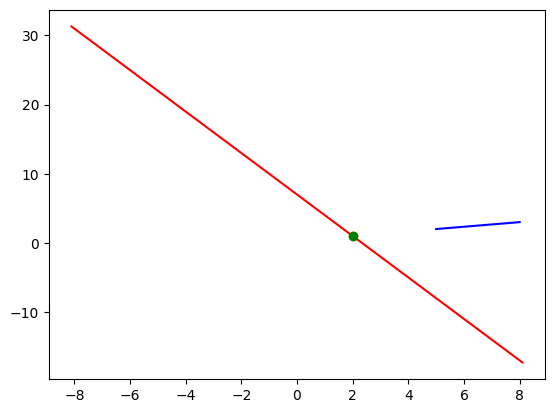

In [127]:
p0 = Point(1.9999963795435443,0.999994640083903,shake=0)
p1 = Point(5.000001760804929,1.9999966583671591,shake=0)
p2 = Point(8.000003952213047,2.999991979966869,shake=0)
SegFromPointToSegDev(p0,Segment(p1,p2))

## Display

## Testing

In [ ]:
Point.Reset()
p1 = Point(1,0, shake=0)
p2 = Point(0,2, shake=0)
p3 = Point(2,2, shake=0)
Point.Reset()
polar_set = SortedDict()      #Points are being sorted according to polar coordinate
polar_set[p1] = None
polar_set[p2] = None
polar_set[p3] = None
for key in polar_set.keys():
    print(key)

1: 1.0   0.0
1: 2.0   2.0
1: 0.0   2.0


In [ ]:
Point.Reset()
p1 = Point(1,0, shake=0)
p2 = Point(0,2, shake=0)
p3 = Point(2,2, shake=0)
p4 = Point(2,3, shake=0)
p5 = Point(1.5,3, shake=0)
p6 = Point(0.003,3, shake=0)
Point.Reset()
xc_set = SortedDict(X_Coord)      #Points are being sorted according to x coordinate
xc_set[p1] = None
xc_set[p2] = None
xc_set[p3] = None
xc_set[p4] = None
xc_set[p5] = None
xc_set[p6] = None
for key in xc_set.keys():
    print(key)

1: 0.0   2.0
1: 0.003   3.0
1: 1.0   0.0
1: 1.5   3.0
1: 2.0   2.0
1: 2.0   3.0


In [101]:
Segment.Reset()
Point.Reset()
p1 = Point(-1,0)
p2 = Point(1,0)
p3 = Point(-2,1)
p4 = Point(2,1)
p5 = Point(0,3)
pentagon = SortedDict()
pentagon[p1] = None
pentagon[p2] = None
pentagon[p3] = None
pentagon[p4] = None
pentagon[p5] = None
pentagon_seg = GetSegments(pentagon)       #working
for k in pentagon_seg.keys():
    if pentagon_seg[k][1]==0:
        print(pentagon_seg[k][0])
    print("\n")

Id: 4
Begin: -1.9999941382890876   1.000013205878434
End: -7.235798629470898e-06   2.999990668064837


Id: 5
Begin: -1.9999937396856255   1.000002766002286
End: -1.0000082311104859   3.5261630297641853e-06




Id: 1
Begin: -0.9999951781740722   -3.2429202649352003e-06
End: 0.9999931580161046   2.4986838535631423e-06




Id: 3
Begin: 3.5160390886162853e-06   2.999985910624449
End: 1.9999925272133603   1.000006863336193




Id: 2
Begin: 1.0000010771118795   1.0585122966679776e-06
End: 1.999991869628304   0.9999997666317516








In [61]:
Point.Reset()
p1 = Point(0,2)
p2 = Point(3,0)
p3 = Point(3,3)
triangle = SortedDict()
triangle[p1] = None
triangle[p2] = None
triangle[p3] = None
triangle_seg = GetSegments(triangle)
for k in triangle_seg.keys():
    if triangle_seg[k][1]==0:
        print(triangle_seg[k][0])
    print("\n")


Id: 8
Begin: -5.899448548219553e-06   1.9999996548210366
End: 2.9999951116464803   4.684899303535853e-06


Id: 7
Begin: -5.449488059863813e-08   2.000006449628235
End: 2.999994767826122   3.0000012505388405




Id: 6
Begin: 2.999994820798211   7.679888322115111e-07
End: 3.000000986455205   3.0000013112992425








In [ ]:
SweepLine(triangle_seg,pentagon_seg)

-2.0000012277344568
Início do segmento 3
Vizinhos de 3: 
-2.000000844071666
Início do segmento 4
Vizinhos de 3: 
4: True
Vizinhos de 4: 
3: False
-1.0000058093528519
Fim do segmento 4
Vizinhos de 3: 
4: True
Vizinhos de 4: 
3: False
-0.9999918556141968
Início do segmento 5
Vizinhos de 3: 
4: True
5: True
Vizinhos de 5: 
3: False
-9.635786216177255e-06
Fim do segmento 3
Vizinhos de 3: 
4: True
5: True
Vizinhos de 5: 
3: False
-1.873987082306191e-06
Início do segmento 2
Vizinhos de 5: 
3: False
2: False
Vizinhos de 2: 
5: True
1.0954041135061962e-05
Início do segmento 8
Vizinhos de 5: 
3: False
2: False
8: False
Vizinhos de 2: 
5: True
8: True
Vizinhos de 8: 
5: True
2: False
1.119415172445094e-05
Início do segmento 7
Vizinhos de 5: 
3: False
2: False
8: False
7: False
Vizinhos de 2: 
5: True
8: True
7: True
Vizinhos de 8: 
5: True
2: False
7: False
Vizinhos de 7: 
5: True
2: False
8: True
0.9999915939511078
Fim do segmento 5
Vizinhos de 5: 
3: False
2: False
8: False
7: False
Vizinhos d

True

[-1.00000362  0.99999368]


(1.414210094519218, <__main__.Point at 0x2499a36db50>)

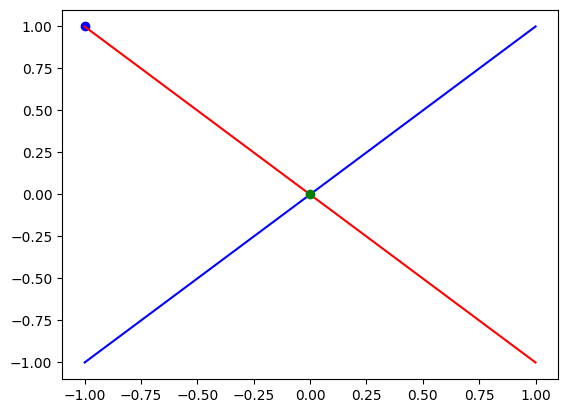

In [99]:
Point.Reset()
p1 = Point(1,1)
p2 = Point(-1,-1)
p0 = Point(-1,1)
s = Segment(p1,p2)
SegFromPointToSegDev(p0, s)

Pentagon:
1: -1.0000009926092888   -9.612147078312659e-06
2: 1.0000090538630737   8.666274466182637e-06
4: 1.9999957456569928   0.9999921160834617
5: 1.1175070564233327e-06   3.0000076250406646
3: -1.9999938055808628   1.0000059114194582
Another triangle:
7: 8.0000086441445   4.850051627663144e-06
8: 8.000007900772152   3.00000318829129
6: 4.999995741022702   1.9999993122568214
closest points: 
Point from hull 0
4: 1.9999957456569928   0.9999921160834617
Next point
5: 1.1175070564233327e-06   3.0000076250406646
distance to the closest of another polygon
inf
Previous point
2: 1.0000090538630737   8.666274466182637e-06
distance to the closest of another polygon
inf
Point from hull 1
6: 4.999995741022702   1.9999993122568214
Next point
7: 8.0000086441445   4.850051627663144e-06
distance to the closest of another polygon
inf
Previous point
8: 8.000007900772152   3.00000318829129
distance to the closest of another polygon
inf
Segment
Id: 5
Begin: 1.9999957456569928   0.9999921160834617
End:

C:\Users\User\AppData\Local\Temp\ipykernel_6100\2508149221.py:19: DeprecationWarning: sorted_dict.iloc is deprecated. Use SortedDict.keys() instead.
  next_point = hulls[i].iloc[next_point_index]


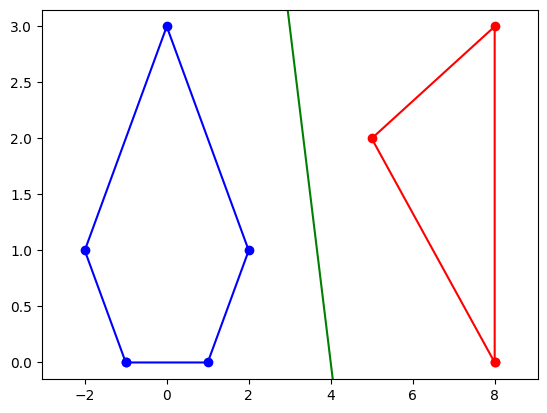

In [135]:
Segment.Reset()
Point.Reset()
p1 = Point(-1,0)
p2 = Point(1,0)
p3 = Point(-2,1)
p4 = Point(2,1)
p5 = Point(0,3)
pentagon = SortedDict()
pentagon[p1] = None
pentagon[p2] = None
pentagon[p3] = None
pentagon[p4] = None
pentagon[p5] = None
p6 = Point(5,2)
p7 = Point(8,0)
p8 = Point(8,3)
another_triangle = SortedDict()
another_triangle[p6] = None
another_triangle[p7] = None
another_triangle[p8] = None
print("Pentagon:")
for k in pentagon.keys():
    print(k)
print("Another triangle:")
for k in another_triangle.keys():
    print(k)
separator = Classificator(pentagon, another_triangle)
another_triangle_seg = GetSegments(another_triangle)
PrintHullsAndSeparator(pentagon, another_triangle,separator)

## Data Load and Modelling

### Obesity Classification(TO-DO)

In [ ]:
#Source = https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition
obesity_data = pd.read_csv("./dataSets/ObesityDataSet_raw_and_data_sinthetic.csv")

In [ ]:
iris_data = pd.read_csv("./dataSets/Iris.csv")

### Spam classification

In [ ]:
#Source = https://archive.ics.uci.edu/dataset/94/spambase
spambase_data = pd.read_csv("./dataSets/spambase/spambase.data",header=None)
pca = PCA(2)
data = pca.fit_transform(spambase_data.iloc[:,:-1])
label = spambase_data.iloc[:,-1]

In [ ]:
#Duas Classes
label.value_counts()

57
0    2788
1    1813
Name: count, dtype: int64

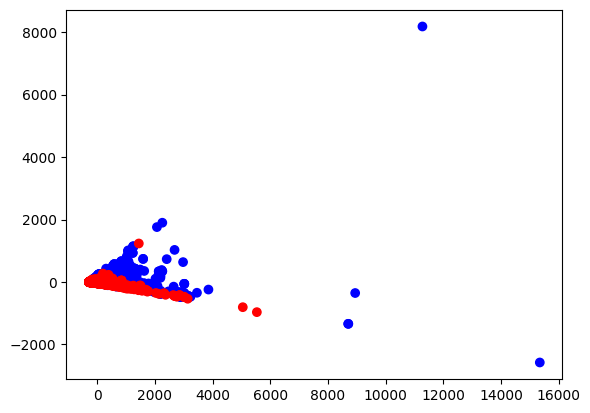

In [ ]:
color = ['red' if l == 0 else 'blue' for l in label]
plt.scatter(data[:,0],data[:,1],color=color)

### Haberman

In [ ]:
#Source = https://archive.ics.uci.edu/dataset/43/haberman+s+survival
haberman = pd.read_csv("./dataSets/haberman+s+survival/haberman.data",header=None)
pca = PCA(2)
data = pca.fit_transform(haberman.iloc[:,:-1])
label = haberman.iloc[:,-1]

In [ ]:
#Duas classes
label.value_counts()

3
1    225
2     81
Name: count, dtype: int64

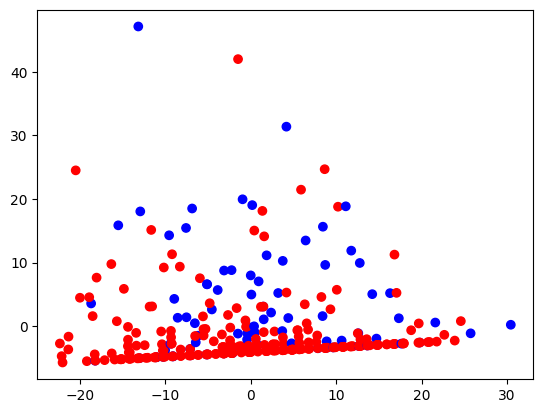

In [ ]:
color = ['red' if l == 1 else 'blue' for l in label]
plt.scatter(data[:,0],data[:,1], color=color)
plt.show()

### Pen Writing Recognition

In [ ]:
#Source = https://archive.ics.uci.edu/dataset/81/pen+based+recognition+of+handwritten+digits
pen_recog_training = pd.read_csv("./dataSets/pen+based+recognition+of+handwritten+digits/pendigits.tra",header=None)
pen_recog_test = pd.read_csv("./dataSets/pen+based+recognition+of+handwritten+digits/pendigits.tes",header=None)
pen_recog = pd.concat([pen_recog_training,pen_recog_test],axis=0)

In [ ]:
pca = PCA(2)
data = pca.fit_transform(pen_recog.iloc[:,:-1])
label_orig = pen_recog.iloc[:,-1]

In [ ]:
#Dez classes
label_orig.value_counts()

16
2    1144
4    1144
1    1143
0    1143
7    1142
6    1056
8    1055
5    1055
9    1055
3    1055
Name: count, dtype: int64

In [ ]:
#Convertida para duas (Se o dígito escrito for menor que 5)
label = (label_orig < 9).astype(int)
label.value_counts()

16
1    9937
0    1055
Name: count, dtype: int64

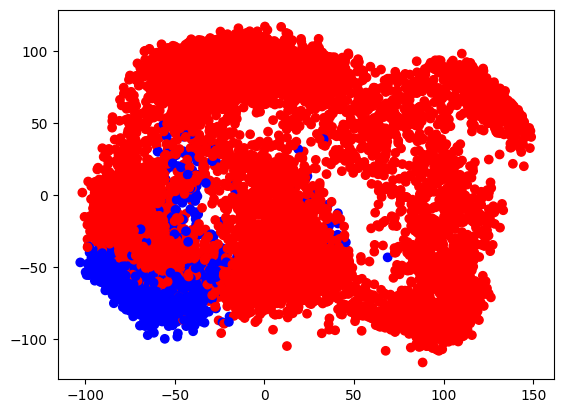

In [ ]:
color = ['red' if l == 1 else 'blue' for l in label]
plt.scatter(data[:,0],data[:,1], color=color)
plt.show()

### Yeast (TO-DO)

In [ ]:
#Source = https://archive.ics.uci.edu/dataset/110/yeast
#Tive que fazer algumas modificações no arquivo direto no excel para mudar a delimitação do arquivo csv e alinhar algumas linhas que não estavam alinhadas com as colunas
yeast = pd.read_csv("./dataSets/yeast/yeast.data.csv",sep=";",header=None)

In [ ]:
pca = PCA(2)
data = pca.fit_transform(pen_recog.iloc[:,:-1])
label_orig = pen_recog.iloc[:,-1]

,0,1,2,3,4,5,6,7,8,9
0,ADT1_YEAST,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,ADT2_YEAST,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,ADT3_YEAST,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,AAR2_YEAST,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,AATM_YEAST,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT
...,...,...,...,...,...,...,...,...,...,...
1479,YUR1_YEAST,0.81,0.62,0.43,0.17,0.5,0.0,0.53,0.22,ME2
1480,ZIP1_YEAST,0.47,0.43,0.61,0.40,0.5,0.0,0.48,0.47,NUC
1481,ZNRP_YEAST,0.67,0.57,0.36,0.19,0.5,0.0,0.56,0.22,ME2
1482,ZUO1_YEAST,0.43,0.40,0.60,0.16,0.5,0.0,0.53,0.39,NUC


### Balance (TO-DO)

In [ ]:
#Source = https://sci2s.ugr.es/keel/dataset.php?cod=54
balance = pd.read_csv("./dataSets/balance.dat.csv",header=None)

### Banana Classification(TO-DO [Maybe Change to another dataset])

In [ ]:
#Source = https://sci2s.ugr.es/keel/dataset.php?cod=182
banana = pd.read_csv("./dataSets/banana.dat",header=None)

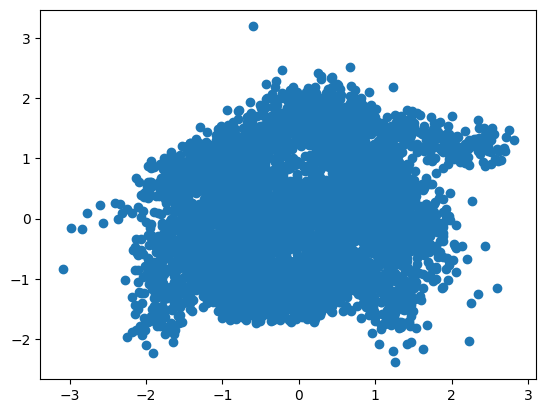

In [ ]:
plt.scatter(banana.iloc[:,0],banana.iloc[:,1])

### Hayes Roth (TO-DO)

In [ ]:
#Source = https://sci2s.ugr.es/keel/dataset.php?cod=186
hayes_r = pd.read_csv("./dataSets/hayes-roth.dat",header=None,sep=",")

### Titanic Survival (TO-DO)

In [ ]:
#Source = https://sci2s.ugr.es/keel/dataset.php?cod=189
titanic = pd.read_csv("./dataSets/titanic.dat",header=None,sep=",")